In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import transforms, models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

2.17.1


In [ ]:
# Let's load train, validation, test arrays
X_train = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_train_images.npy')
Y_train = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_train_label.npy')
X_val = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_val_images.npy')
Y_val = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_val_label.npy')
X_test = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_test_images.npy')
Y_test = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_test_label.npy')

In [ ]:
print("X_train length:", len(X_train))
print("X_train shape:", X_train.shape)
print("Y_train length:", len(Y_train))
print("Y_train shape:", Y_train.shape)

print("X_val length:", len(X_val))
print("X_val shape:", X_val.shape)
print("Y_val length:", len(Y_val))
print("Y_val shape:", Y_val.shape)

print("X_test length:", len(X_test))
print("X_test shape:", X_test.shape)
print("Y_test length:", len(Y_test))
print("Y_test shape:", Y_test.shape)

X_train length: 1200
X_train shape: (1200, 160, 160)
Y_train length: 1200
Y_train shape: (1200,)
X_val length: 215
X_val shape: (215, 160, 160)
Y_val length: 215
Y_val shape: (215,)
X_test length: 250
X_test shape: (250, 160, 160)
Y_test length: 250
Y_test shape: (250,)


In [ ]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [ ]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


In [ ]:
# Count the occurrences of each class label in Y_train
class_counts = Counter(Y_train)

# Print the class distribution
print("Class Distribution in Y_train:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count / len(Y_train) * 100:.2f}%)")

# Check for class imbalance (you can define a threshold for imbalance)
imbalance_threshold = 0.2  # Example: 20% difference between the largest and smallest class
if max(class_counts.values()) / min(class_counts.values()) > (1 + imbalance_threshold):
  print("\nWARNING: Class imbalance detected in Y_train")
else:
  print("\nClass distribution appears relatively balanced.")

Class Distribution in Y_train:
Class 1: 505 samples (42.08%)
Class 0: 460 samples (38.33%)
Class 2: 235 samples (19.58%)



In [ ]:
# Convert NumPy arrays to PyTorch tensors with channel-first format
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)


In [ ]:
X_train_tensor.shape

torch.Size([1200, 3, 160, 160])

### Data Augmentation

In [ ]:
# Modified transforms with custom normalization
data_augmentation_resNet50 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

### Create a Custom Dataset Class

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


### Creation Dataset

In [ ]:
# Training Dataset with Augmentation
dataset_train = AugmentedDataset(
    X_train_tensor,
    Y_train_tensor,
    transform=data_augmentation_resNet50
)

# Validation Dataset with Preprocessing Only
dataset_val = AugmentedDataset(
    X_val_tensor,
    Y_val_tensor,
    transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.485, 0.485, 0.485],
                        std=[0.229, 0.229, 0.229])])
)

# Test Dataset without Augmentations
dataset_test = TensorDataset(X_test_tensor, Y_test_tensor)

### DataLoader Creation

In [ ]:
batch_size = 16
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

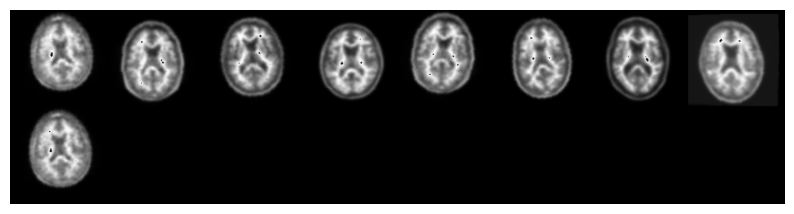

In [ ]:
for images, labels in dataloader_train:
    # Unnormalize the images (if normalization was applied)
    mean = torch.tensor([0.485, 0.485, 0.485]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(1, 3, 1, 1)
    images = images * std + mean  # Reverse normalization

    # Create a grid of images
    grid = torchvision.utils.make_grid(images[:9])  # First 9 images

    # Plot the images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))  # Transpose dimensions (C, H, W) -> (H, W, C)
    plt.axis('off')
    plt.show()
    break  # Display one batch only


### Load Pretrained model



In [ ]:
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze all layers except the final block
        for name, param in self.base_model.named_parameters():
            if "layer4" in name:  # Unfreeze only the final residual block
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Replace the fully connected layer with a custom classifier
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),  # Fully connected layer
            nn.ReLU(),                     # Activation
            nn.BatchNorm1d(512),           # Batch normalization
            nn.Dropout(0.5),               # Dropout for regularization
            nn.Linear(512, num_classes)    # Final output layer
        )

    def forward(self, x):
        """
        Forward pass for the model.
        :param x: Input tensor.
        :return: Output logits.
        """
        return self.base_model(x)


### Replace the final fully connected layer

In [ ]:
num_classes = 3
restNet50_model = ResNet50Classifier(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
restNet50_model= restNet50_model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


### Setting up Loss, optimizer and scheduler

In [ ]:
# Higher initial learning rate
optimizer = optim.Adam([
        {'params': restNet50_model.base_model.fc.parameters(), 'lr': 1e-3},
        {'params': (p for n, p in restNet50_model.base_model.named_parameters() if 'fc' not in n and p.requires_grad), 'lr': 1e-4}
    ])

In [ ]:
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

### Train Phase

### Training Model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    """
    Train and validate a model.

    :param model: PyTorch model
    :param dataloader_train: DataLoader for training data
    :param dataloader_val: DataLoader for validation data
    :param criterion: Loss function
    :param optimizer: Optimizer
    :param scheduler: Learning rate scheduler
    :param num_epochs: Number of training epochs
    :param device: Device to train on ('cuda' or 'cpu')
    :return: Training and validation history
    """
    model = model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            if isinstance(outputs, tuple):  # Handle models with auxiliary outputs (e.g., InceptionV3)
                main_output, aux_output = outputs
                loss1 = criterion(main_output, labels)
                loss2 = criterion(aux_output, labels)
                loss = loss1 + 0.4 * loss2  # Weighted loss
            else:  # Handle models with a single output (e.g., ResNet50)
                loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs[0].max(1) if isinstance(outputs, tuple) else outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                if isinstance(outputs, tuple):  # Handle auxiliary outputs during validation
                    outputs = outputs[0]
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return history

In [ ]:
 # Train for more epochs
history = train_model(restNet50_model, dataloader_train, dataloader_train, criterion, optimizer, scheduler,
                         num_epochs=10, device=device)

Epoch 1/6:
Train Loss: 1.1479, Train Acc: 30.92%
Val Loss: 1.1213, Val Acc: 29.00%
Validation loss decreased. Saving model to best_model.pth
Epoch 2/6:
Train Loss: 1.1524, Train Acc: 32.92%
Val Loss: 1.1362, Val Acc: 19.25%
EarlyStopping counter: 1 out of 3
Epoch 3/6:
Train Loss: 1.1498, Train Acc: 29.58%
Val Loss: 1.1356, Val Acc: 20.17%
EarlyStopping counter: 2 out of 3
Epoch 4/6:
Train Loss: 1.1521, Train Acc: 28.92%
Val Loss: 1.1349, Val Acc: 20.17%
EarlyStopping counter: 3 out of 3
Early stopping triggered. Stopping training.


FileNotFoundError: [Errno 2] No such file or directory: 'best_model1.pth'